In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/titanic.txt


In [31]:
import pandas as pd
import numpy as np

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')
df.head()

,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
df.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
appearance    101
stage          24
pchemo          1
Wardsize      145
finalhisto     10
nodeyiel       12
RHlvsi        366
depth         489
size          114
utmet          98
vgmargin       96
vgmet          97
pelvicme        1
pmmet          94
adnmet          7
dtype: int64

In [34]:
df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis=1)
df_clean_column.isnull().sum(axis=0)

age             0
parity          0
hiv             4
menopaus        1
disease         0
surgery         0
conization      5
OPDsize        17
stage          24
pchemo          1
finalhisto     10
size          114
utmet          98
vgmet          97
pmmet          94
dtype: int64

In [35]:
df_clean = df_clean_column.dropna(axis=0)

In [36]:
pm_class = np.unique(df_clean['pmmet'])
pm_class

array([0., 1.])

In [37]:
pm_value = [sum(df_clean['pmmet'] == pm_class[0]),sum(df_clean['pmmet'] == pm_class[1])]
pm_value

[1278, 277]

In [38]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis=1).values

In [39]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=1)
X_res,y_res = sm.fit_resample(X,y)

In [40]:
from sklearn.model_selection import train_test_split
X,X_res,y,y_res = train_test_split(X,y,test_size=0.2,random_state=0)

In [41]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range=(0,1)) #สร้าง Model และแปลงค่าใหอยู่ในช่วง 0-1
scaler.fit(X)
X_train_norm = scaler.transform(X)
X_test_norm = scaler.transform(X_res)

In [42]:
from sklearn.metrics import make_scorer, accuracy_score
# ML Model selection
from sklearn.model_selection import GridSearchCV
# CatBoost model
from catboost import CatBoostClassifier, Pool

In [50]:
clf = CatBoostClassifier()
params = {'iterations': [500],
          'depth': [4, 5, 6],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [10],
#           'eval_metric': ['Accuracy'],
#           'use_best_model': ['True'],
          'logging_level':['Silent'],
          'random_seed': [42]
         }
scorer = make_scorer(accuracy_score)
clf_grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scorer, cv=10)


In [51]:
clf_grid.fit(X_train_norm, y)
best_param = clf_grid.best_params_
best_param

{'depth': 5,
 'iterations': 500,
 'l2_leaf_reg': 1e-20,
 'leaf_estimation_iterations': 10,
 'logging_level': 'Silent',
 'loss_function': 'Logloss',
 'random_seed': 42}

In [52]:
model = CatBoostClassifier(iterations=500,
                           loss_function=best_param['loss_function'],
                           depth=best_param['depth'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           eval_metric='Accuracy',
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           logging_level='Silent',
                           random_seed=42
                          )

In [53]:
train_pool = Pool(X_train_norm, y,)

In [54]:
model.fit(train_pool, eval_set=(X_res,y_res))

In [55]:
import scikitplot as skplt
import seaborn as sns
sns.set()

In [65]:
from catboost import CatBoostClassifier
catboost = CatBoostClassifier() 

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = catboost,X = X_train_norm, y = y, cv = 10)
print("Accuracy:{:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation:{:.2f} %".format(accuracies.std()*100))

Accuracy:81.99 %
Standard Deviation:1.94 %


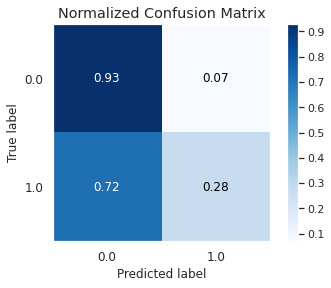

In [56]:
y_train_pred = model.predict(X)
skplt.metrics.plot_confusion_matrix(y, y_train_pred, normalize=True)

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y,y_train_pred,target_names=target_names))

              precision    recall  f1-score   support

    negative       0.85      0.93      0.89      1020
    positive       0.47      0.28      0.35       224

    accuracy                           0.81      1244
   macro avg       0.66      0.60      0.62      1244
weighted avg       0.78      0.81      0.79      1244

